
TIME TO DEPLOY THE WRAPPING PROCESS:
2.619537353515625 s
---------------------


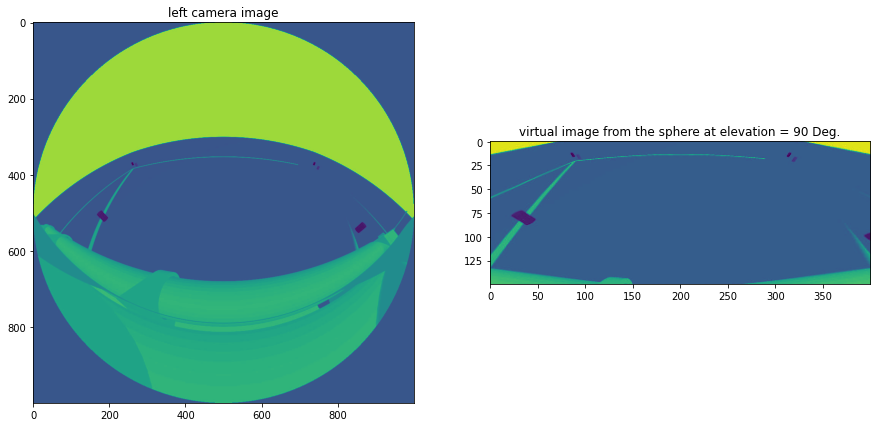

In [7]:
import numpy as np
import cv2
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy.interpolate import interp2d
from numpy.linalg import inv
import time
import argparse

#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#INITIAL PARAMETERS------------------------------------------------------------------------------------------------------

frame                 =  cv2.cvtColor(cv2.imread('image/left_gs72_ideal.jpg'),cv2.COLOR_BGR2GRAY) 
steps                 =  1000
pix4unit              =  (1/(steps/2)) 
u0,v0                 = (steps/2) , (steps/2)
f_vir, sx_vir, sy_vir =  0.1, 0.0005, 0.0005 
width_vir, height_vir =  400,150
roll, pitch           =  0,0

#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#FIRST INTERPOLATION FOR WRAPPING----------------------------------------------------------------------------------------

x             =  np.linspace(0, steps, steps) 
inter_frame   =  interp2d(x,x,frame,kind='linear',fill_value='-1')  
u0_vir,v0_vir =  (width_vir/2), (height_vir/2)
k_vir         =  np.array([[f_vir/sx_vir,0,u0_vir],[0,f_vir/sy_vir,v0_vir],[0,0,1]]) 
k_vir_inv     =  inv(k_vir)                                                          

#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#SUBFUNCTION TO EXTRACT THE COORDINATES OF THE PIXELS THAT ARE REMAPPED--------------------------------------------------

def wrap_grid(k_vir_inv, roll, pitch, width_vir, height_vir, u0, v0, pix4unit ):
    
    r2d  = (180/np.pi) 
    rot  = np.array([[np.cos(pitch/r2d),                           0,                 np.sin(pitch/r2d)],
                     [(np.sin(pitch/r2d))*(np.sin(roll/r2d)),      np.cos(roll/r2d),  (-1)*(np.cos(pitch/r2d))*(np.sin(roll/r2d))],
                     [(-1)*(np.sin(pitch/r2d))*(np.cos(roll/r2d)), np.sin(roll/r2d),  np.cos(pitch/r2d)*np.cos(roll/r2d) ]])

    coord=np.zeros([width_vir, height_vir,2],float) 
    
    for u in range (0, width_vir):
        for v in range (0, height_vir):
            
            v_im_cor      =  np.matmul(k_vir_inv, np.array([[u],[v],[1]]))                    
            v_im_cor      =  np.matmul(rot, v_im_cor)                            
            mod           =  np.sqrt(( np.power(v_im_cor[0],2) ) + ( np.power(v_im_cor[1],2) ) + ( np.power(v_im_cor[2],2) ) )  
            v_im_cor_unit =  v_im_cor/mod
            v_im_cor_unit =  v_im_cor/mod        
            coord[u,v,0]  =  v_im_cor_unit[0] / pix4unit + u0
            coord[u,v,1]  =  v_im_cor_unit[1] / pix4unit + v0  
              
    return coord

#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#SUBFUNCTION TO REMAPP THE PIXELS (VALUE OF THE PIXELS)------------------------------------------------------------------

def remap_pixels(inter_frame, coord, width_vir, height_vir):
    
    v_im = np.zeros([width_vir, height_vir],float)
    
    for u in range (0, width_vir):
        for v in range (0, height_vir):
            
            x,y = coord[u,v,0], coord[u,v,1]     
            v_im[u,v] = inter_frame(x,y)
    
    return v_im
#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

#MAIN SEQUENCE: (uning the image of the left camera this time)
coord =  wrap_grid(k_vir_inv, roll, pitch, width_vir, height_vir, u0, v0, pix4unit)     

t2    =  time.time()
v_img =  remap_pixels(inter_frame, coord, width_vir, height_vir)

elapsed = time.time() - t2
print('\n'+'TIME TO DEPLOY THE WRAPPING PROCESS:'+'\n'+ str(elapsed)+' '+'s' +'\n'+'---------------------' )   

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 15),  sharey=False)

ax1.set_title('left camera image')
ax2.set_title('virtual image from the sphere at elevation = 90 Deg.')
x  = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
ax1.imshow((frame)) 
ax2.imshow(np.transpose(v_img)) 